In [1]:
# Gradient Boosting Model
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import shap

c:\Users\kylie\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
master_df = pd.read_csv('master.csv')
# Assuming master_df contains your data and 'Date' is a datetime column
data = master_df.copy()

# Drop unnecessary columns and missing values if needed
# data.dropna(inplace=True)  # Uncomment this line if you have missing values and want to drop them

# Split data into features (X) and target variable (y)
X = data[['Day of Week', 'feelslike', 'precip', 'snowdepth', 
          'windgust', 'windspeed', 'solarradiation', 'solarenergy', 
          'uvindex', 'moonphase', 'Holiday', 'cloudcover']]
y = data['count']

X = pd.get_dummies(X)
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)



In [3]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.9, learning_rate = 0.2,
                max_depth = 5, alpha = 5, n_estimators = 300)
xg_reg.fit(X_train, y_train)

# Get predicted counts
y_pred = xg_reg.predict(X_test)
#'min_child_weight': 3'subsample': 0.7

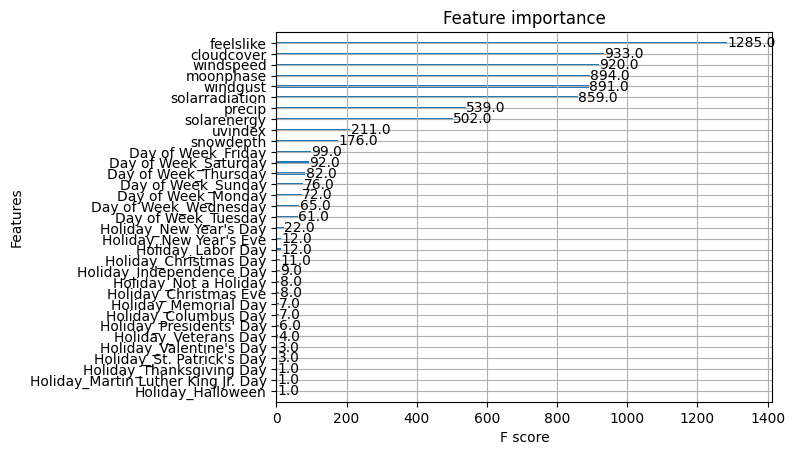

Mean Squared Error: 1.6286498808187702


In [4]:
xgb.plot_importance(xg_reg)
plt.show()

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

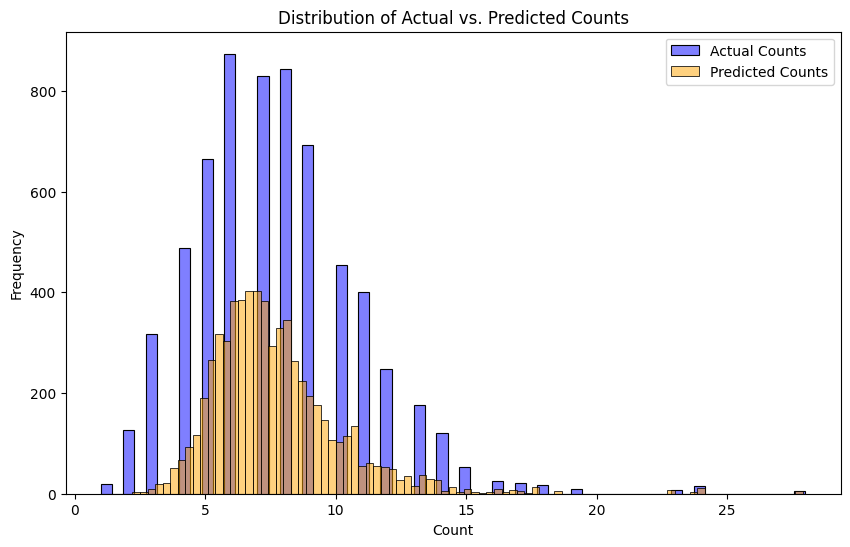

In [5]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(y_test, color='blue', alpha=0.5, label='Actual Counts')
sns.histplot(y_pred, color='orange', alpha=0.5, label='Predicted Counts')
plt.title('Distribution of Actual vs. Predicted Counts')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()


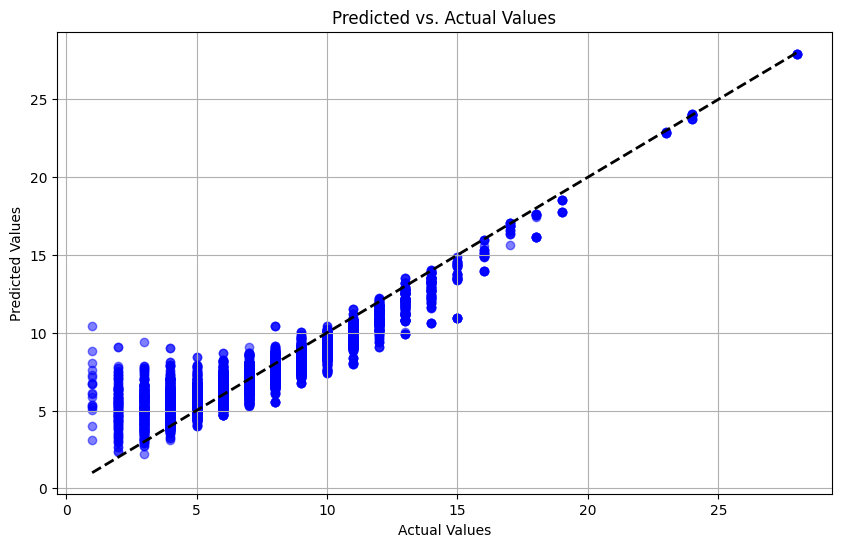

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

In [7]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    # 'min_child_weight': [1, 3, 5],
    # 'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'n_estimators': [100, 200, 300],
    'alpha': [0, 0.1, 0.5],
    'lambda': [0, 0.1, 0.5]
}

In [9]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Perform Grid Search CV
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", -grid_search.best_score_)

# Get predicted counts using the best model
best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters: {'alpha': 0, 'colsample_bytree': 0.9, 'lambda': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
Best Score: 1.6364056335732406


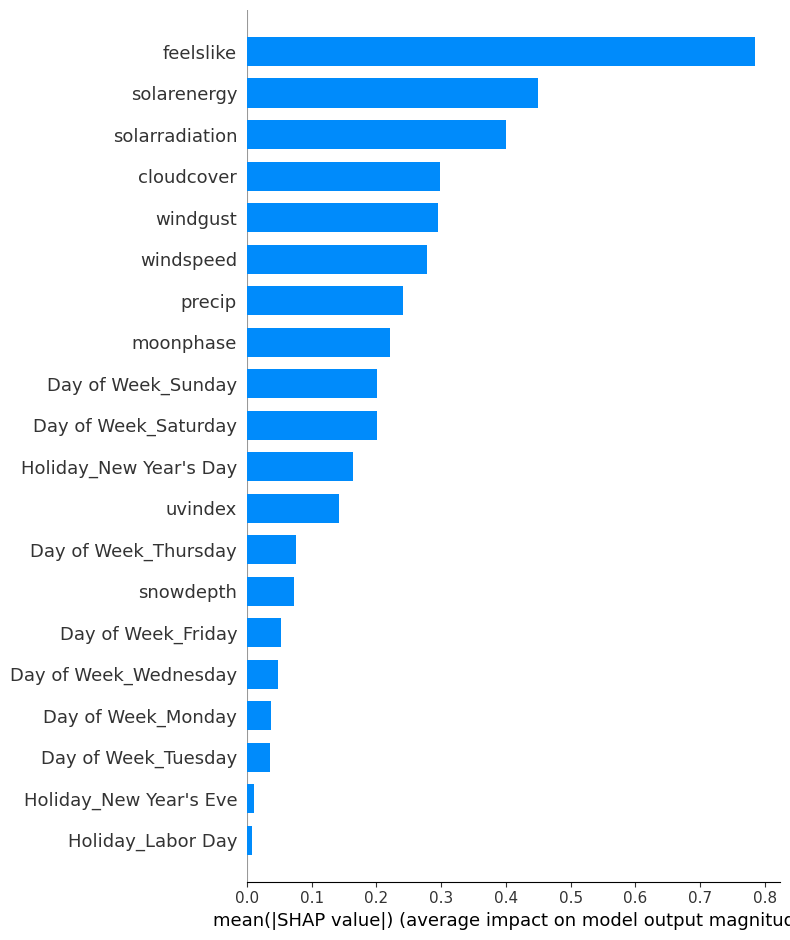

In [8]:
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

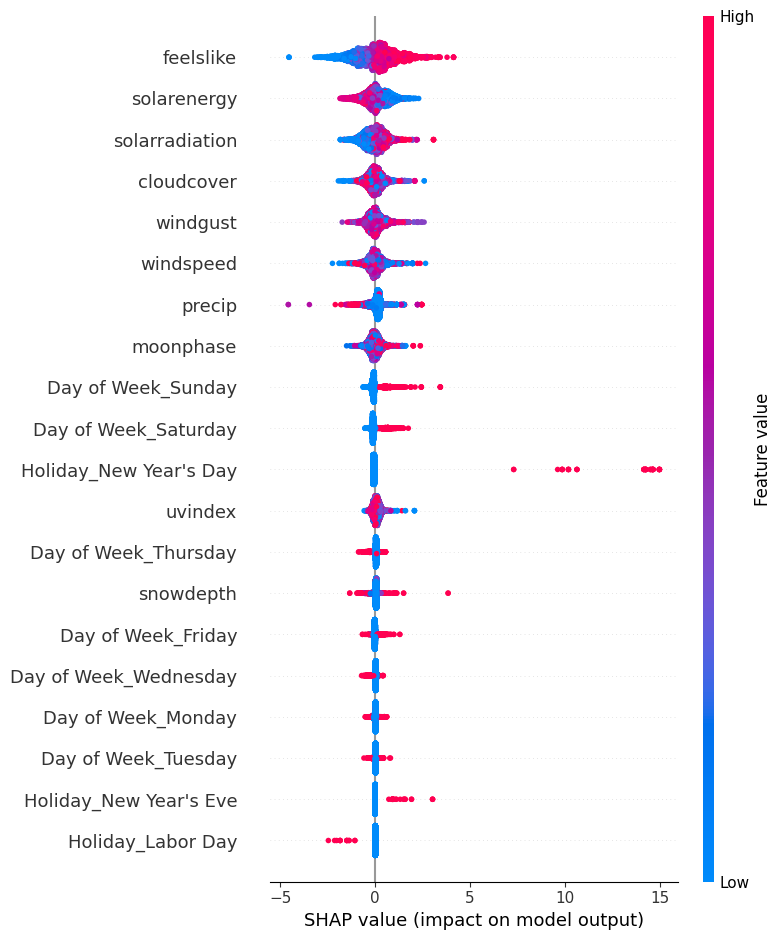

In [9]:
shap.summary_plot(shap_values, X_test, plot_type='dot')

In [13]:
shap_values

array([[ 1.0591419e+00,  1.4778723e-01,  3.3511147e-02, ...,
         2.2675229e-04,  8.1973747e-05,  5.0549489e-04],
       [ 7.2562121e-02,  1.2896447e-01,  9.6295308e-03, ...,
         2.3144766e-04,  7.7389835e-05,  2.9581331e-04],
       [-1.2452462e+00, -4.1527882e-02, -3.9794140e-02, ...,
         4.0810904e-05,  5.1583158e-04,  7.8862475e-04],
       ...,
       [-1.3266563e+00, -2.7854437e-01, -1.1699451e-01, ...,
         4.0810904e-05,  5.1362411e-04,  8.4259076e-04],
       [ 8.6516005e-01,  1.6300787e-01,  2.1949643e-02, ...,
         2.3144766e-04,  8.0053447e-05,  8.4882916e-04],
       [-7.3259073e-01,  2.8963926e-01, -2.7388632e-01, ...,
         3.9452905e-05,  4.9699424e-04,  5.6370598e-04]], dtype=float32)